## Final project
### Image calibration
### Subject: Optimization and Metaheuristics II
### Professor: Claudia Nallely Sánchez Gómez
### Students: 
### María Cristina Velázquez García  0224433
### María Fernanda Zavala López  0227729


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Image processing 

In [2]:
def getCornersofContour(contour):
    corners = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)
    return corners

def getBiggestContour(contours):
    c = max(contours, key = cv2.contourArea)
    return c

def getContours(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    _, thresh = cv2.threshold(gray, 200, 255, 0)
    plt.imshow(thresh,cmap="gray")    
    plt.show()
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def transformImage(img, corners,w=500,h=500):
    corners = np.concatenate(corners).tolist()
    corners = sorted(corners,key=lambda x:np.linalg.norm([np.array([0,0])] - np.array(x)))      
    pts1 = np.float32(corners)
    pts2 = np.float32([[0,0],[0,h],[w,0],[w,h]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    result = cv2.warpPerspective(img,matrix,(h,w))
    return result


def compareColors(color1, color2):
    return np.sum(np.abs(color1-color2))

def getColorOfPixel(image, y, x, WPices = 6, HPices = 4,radius = 3):
    w = image.shape[1]
    h = image.shape[0]

    wPiece = w/WPices
    hPiece = h/HPices
    x *= wPiece
    y *= hPiece
    x = int(x-wPiece//2)
    y = int(y-hPiece//2)
    return image[y:y+radius, x:x+radius]
    
def getAllColors(img1,img2, WPices = 6, HPices = 4):
    img1Colors = []
    img2Colors= []
    
    for i in range(HPices):
        for j in range(WPices):
            
            img1Colors.append(getColorOfPixel(img1, i, j, WPices, HPices))
            img2Colors.append(getColorOfPixel(img2, i, j, WPices, HPices))
    
    return np.array(img1Colors),np.array(img2Colors)

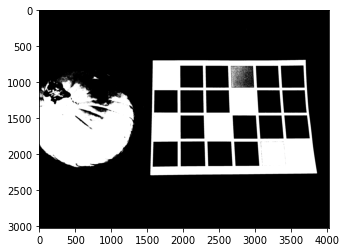

In [3]:
imageColorOriginal = cv2.imread('images/test2.png')
imageColorOriginal = cv2.cvtColor(imageColorOriginal, cv2.COLOR_BGR2RGB)

image = cv2.imread('images/pumpkin.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image*.9
image = image.astype(np.uint8)
c = getContours(255-image)

biggest_contour = getBiggestContour(c)
corners = getCornersofContour(biggest_contour)

result = transformImage(image, corners)
# reshape image to imageColorOriginal
result = cv2.resize(result, (imageColorOriginal.shape[1], imageColorOriginal.shape[0]))

cv2.drawContours(image, [corners], 0, (0, 255, 0), 2)
for i in range(len(corners)):
    cv2.circle(image, tuple(corners[i][0]), 52, (0, 0, 255), -1)

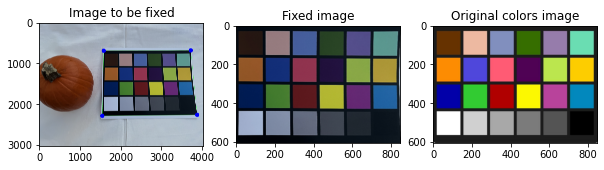

In [4]:
imageColorOriginal = cv2.imread('images/test2.png')
imageColorOriginal = cv2.cvtColor(imageColorOriginal, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))

plt.subplot(131), plt.imshow(image), plt.title('Image to be fixed')
plt.subplot(132), plt.imshow(result), plt.title('Fixed image')
plt.subplot(133), plt.imshow(imageColorOriginal), plt.title('Original colors image')

plt.show()

## Use of Differential Evolution to calibrate the image's colors

In [5]:
from differential_evolution import differential_evolution

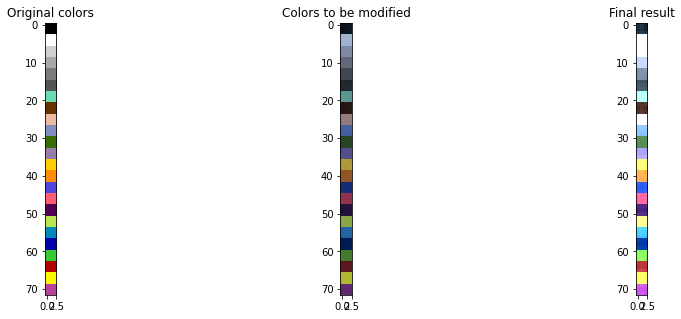

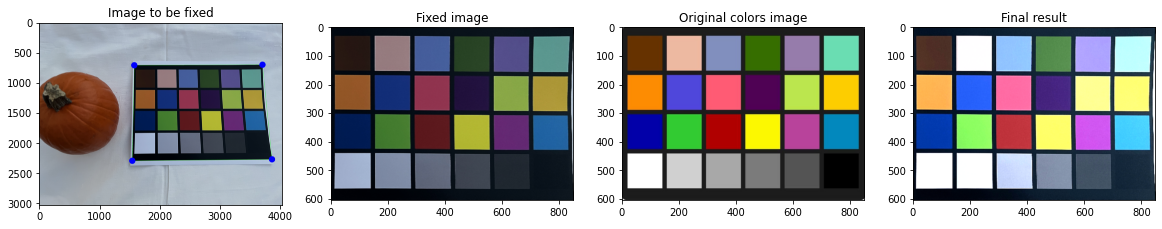

{'It': 2000, 'Vals': array([ 0.01365377, -1.67281225,  1.73393783,  0.71668385,  1.17304511,
        0.03113764, -0.36115568, -1.15656822,  1.61838727]), 'Fit': 35195}
{'It': 2000, 'Vals': array([ 0.01365377, -1.67281225,  1.73393783,  0.71668385,  1.17304511,
        0.03113764, -0.36115568, -1.15656822,  1.61838727]), 'Fit': 35195}


In [6]:
def objective_function(x, img1Colors,img2Colors):
    x = x.reshape((3,3))
    imageColor =  cv2.filter2D(img1Colors, -1, x)     
    return np.sum(np.abs(imageColor-img2Colors)) 

def plotFunction(x, img1Colors,img2Colors):
    clear_output(wait=True)
    x = x.reshape((3,3))
    imageColor =  cv2.filter2D(img1Colors, -1, x)   

    plt.figure(figsize=(15,5))
    plt.subplot(131), plt.imshow(img2Colors), plt.title('Original colors')
    plt.subplot(132), plt.imshow(img1Colors), plt.title('Colors to be modified')
    plt.subplot(133), plt.imshow(imageColor), plt.title('Final result')
    plt.show()
    global image
    global result
    global imageColorOriginal
    
    plt.figure(figsize=(20,15))
    plt.subplot(141), plt.imshow(image), plt.title('Image to be fixed')
    plt.subplot(142), plt.imshow(result), plt.title('Fixed image')
    plt.subplot(143), plt.imshow(imageColorOriginal), plt.title('Original colors image')
    plt.subplot(144), plt.imshow(cv2.filter2D(result,-1,x)), plt.title('Final result')
    plt.show()



    
img1Colors,img2Colors = getAllColors(result,imageColorOriginal)
img1Colors = np.concatenate(img1Colors,axis=0)
img2Colors = np.concatenate(img2Colors,axis=0)
bounds = np.array([[-2,2],[-2,2],[-2,2],[-2,2],[-2,2],[-2,2],[-2,2],[-2,2],[-2,2]])
x = differential_evolution(objective_function,bounds, args=(img1Colors,img2Colors), popsize=200, plotFunction=plotFunction)
print(x)


[ 0.01365377 -1.67281225  1.73393783  0.71668385  1.17304511  0.03113764
 -0.36115568 -1.15656822  1.61838727]
[[ 0.01365377 -1.67281225  1.73393783]
 [ 0.71668385  1.17304511  0.03113764]
 [-0.36115568 -1.15656822  1.61838727]]


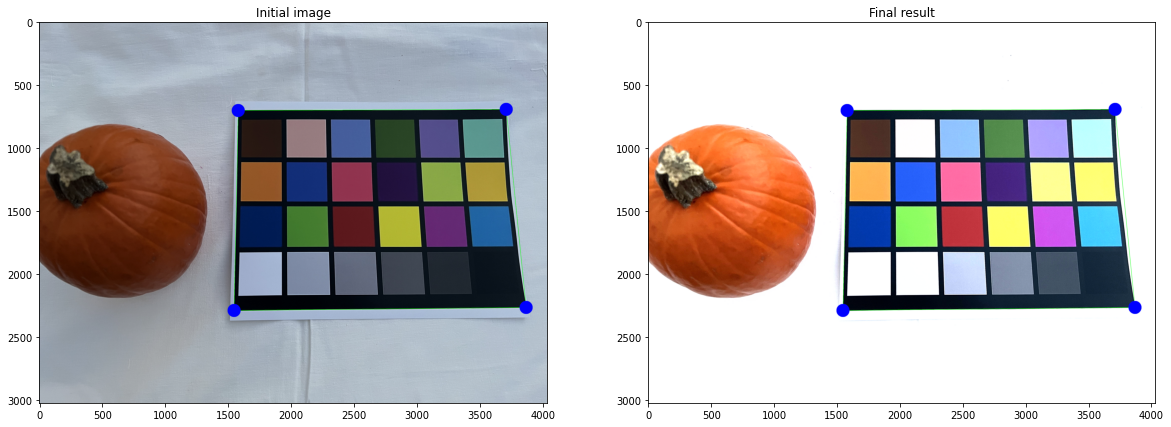

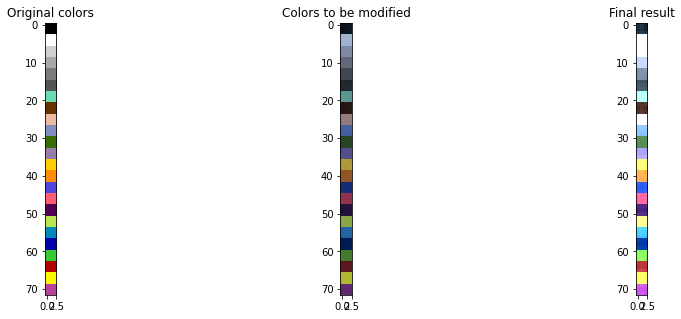

In [7]:
print(x['Vals'])
transformationKernel= x['Vals']
transformationKernel = transformationKernel.reshape((3,3))
print(transformationKernel)
resultimage= image.copy()
finalimage =  cv2.filter2D(resultimage, -1, transformationKernel)

plt.figure(figsize=(20,15))
plt.subplot(121), plt.imshow(image), plt.title('Initial image')
plt.subplot(122), plt.imshow(finalimage), plt.title('Final result')
plt.show()

imageColor =  cv2.filter2D(img1Colors, -1, transformationKernel)

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(img2Colors), plt.title('Original colors')
plt.subplot(132), plt.imshow(img1Colors), plt.title('Colors to be modified')
plt.subplot(133), plt.imshow(imageColor), plt.title('Final result')
plt.show()

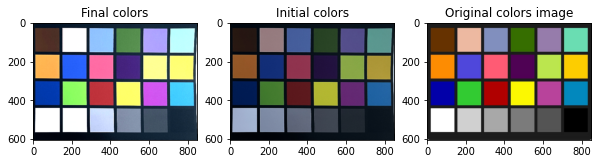

In [8]:
imagefinal =  cv2.filter2D(result, -1, transformationKernel)
plt.figure(figsize=(10,10))
plt.subplot(131), plt.imshow(imagefinal), plt.title('Final colors')
plt.subplot(132), plt.imshow(result), plt.title('Initial colors')
plt.subplot(133), plt.imshow(imageColorOriginal), plt.title('Original colors image')
plt.show()

## Comparing the images

### SSIM

Comparison between final images

In [9]:
import skimage
from skimage.metrics import structural_similarity as ssim
gray1 = cv2.cvtColor(imageColorOriginal, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(imagefinal, cv2.COLOR_BGR2GRAY)
s = ssim(gray1, gray2)
print(s)


0.6803491007835255


Same comparison before applying the kernel

In [5]:
import skimage
from skimage.metrics import structural_similarity as ssim

original_image = cv2.imread('images/test2.png')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

input_image = result.copy()
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

gray1 = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
s = ssim(gray1, gray2)
print(s)

0.6941920392291475


### Histogram comparison

Comparison between final images

In [10]:
hsv_original_colors = cv2.cvtColor(imageColorOriginal, cv2.COLOR_BGR2HSV)
hsv_final_image = cv2.cvtColor(imagefinal, cv2.COLOR_BGR2HSV)

h_bins = 50
s_bins = 60
histSize = [h_bins, s_bins]
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges
channels = [0, 1]

hist_original_colors = cv2.calcHist([hsv_original_colors], channels, None, histSize, ranges, accumulate=False)
cv2.normalize(hist_original_colors, hist_original_colors, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
hist_final_image = cv2.calcHist([hsv_final_image], channels, None, histSize, ranges, accumulate=False)
cv2.normalize(hist_final_image, hist_final_image, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

compare_method = cv2.HISTCMP_CORREL

original_original = cv2.compareHist(hist_original_colors, hist_original_colors, compare_method)
original_final = cv2.compareHist(hist_original_colors, hist_final_image, compare_method)

print('original_original Similarity = ', original_original)
print('original_final Similarity = ', original_final)


original_original Similarity =  1.0
original_final Similarity =  0.771527917509721


Same comparison before applying the kernel

In [7]:
hsv_original_colors = cv2.cvtColor(imageColorOriginal, cv2.COLOR_BGR2HSV)
hsv_final_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

h_bins = 50
s_bins = 60
histSize = [h_bins, s_bins]
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges
channels = [0, 1]

hist_original_colors = cv2.calcHist([hsv_original_colors], channels, None, histSize, ranges, accumulate=False)
cv2.normalize(hist_original_colors, hist_original_colors, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
hist_final_image = cv2.calcHist([hsv_final_image], channels, None, histSize, ranges, accumulate=False)
cv2.normalize(hist_final_image, hist_final_image, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

compare_method = cv2.HISTCMP_CORREL

original_original = cv2.compareHist(hist_original_colors, hist_original_colors, compare_method)
original_final = cv2.compareHist(hist_original_colors, hist_final_image, compare_method)

print('original_original Similarity = ', original_original)
print('original_final Similarity = ', original_final)

original_original Similarity =  1.0
original_final Similarity =  1.8966037422085346e-05


### Macro f1

Comparison between final images

In [11]:
from sklearn.metrics import f1_score
image1_flatten = imageColorOriginal.flatten()
image2_flatten = imagefinal.flatten()
print(f1_score(image1_flatten, image2_flatten, average='macro'))

0.004095556517151343


Same comparison before applying convolution kernel

In [8]:
from sklearn.metrics import f1_score
image1_flatten = imageColorOriginal.flatten()
image2_flatten = input_image.flatten()
print(f1_score(image1_flatten, image2_flatten, average='macro'))

0.001734204391394911
